This notebook will introduce you to `kcgof` (kernel conditional goodness-of-fit testing), a Python package implementing two kernel-based conditional goodness-of-fit tests as described in

    Testing Goodness of Fit of Conditional Density Models with Kernels
    Wittawat Jitkrittum, Heishiro Kanagawa, Bernhard Schölkopf
    UAI 2020
    https://arxiv.org/abs/2002.10271

See [the Github page](https://github.com/wittawatj/kernel-cgof) for more information.

Make sure that you have `kcgof` included in Python's search path. In particular the following import statements should not produce any fatal error. For how to install software dependencies, see the [README](https://github.com/wittawatj/kernel-cgof). In our code, we use [Pytorch](https://pytorch.org/).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch

import kcgof
import kcgof.log as klog
import kcgof.util as util
import kcgof.cdensity as cden
import kcgof.cdata as cdat
import kcgof.cgoftest as cgof
import kcgof.kernel as ker
import kcgof.plot as plot

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 20
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Conditional Goodness-of-fit testing

Given a known conditional density model $p(y|x)$ and a sample $\{ (x_i, y_i) \}_{i=1}^n \sim r(y|x) r_x(x)$ where $q$ is the true (unknown) conditional distribution generating the data, and $r$ is the marginal distribution for $x$, a conditional goodness-of-fit test proposes the following null hypothesis

$H_0: p(y|x) = r(y|x) \, \text{for almost all}\, x,y$ 

against the alternative hypothesis $H_1$ which is simply the negation of $H_0$.

In other words, it tests whether or not the sample follows the model $p(y|x)$, for some marginal distribution $r$. Note that the model does not specify the marginal distribution $r_x$.

## Our work

We propose two new tests: 

1. The Kernel Conditional Stein Discrepancy (KCSD)
2. The Finite Set Conditional Discrepancy (FSCD)

The KCSD test makes a few mild assumptions on the distributions $p$ and $r$. 
The model $p(y|x)$ can take almost any form as long as it is differentiable. 
The normalizer of $p(y|x)$ (which is $p(x)$) is not assumed known. 
The test only assesses the goodness of the model through $\nabla_{y} \log p(y|x)$ i.e., the first derivative of the log conditional density. The FSCD is an extention of KCSD to return an interpretable set of locations in the space of $x$ that indicate where $p(y|x)$ differs from $r(y|x)$.


### Specifying your model $p(y|x)$

In our code, a model $p(y|x)$ is represented as an instance of class `kcgof.cdensity.UnnormalizedCondModel`. You can subclass this class and implement your model. Alternatively, you can represent your model by the following convenient method that will construct an instance of this class for you.

        kcgof.cdensity.from_log_den(dx, dy, f)
        
where:
* `dx` is the dimension of x (positive integer)
* `dy` is the dimension of y (positive integer)
* `f` is a callable (e.g., a function) that takes two arguments `(X, Y)`, where X: n x dx, Y: n x dy Torch tensors, and evaluates the unnormalized conditional density of the model i.e., p(x,y) (up to any multiplicative factor that is a function of x). Return a Torch array of length n, representing $[ c(x_1) \cdot p(x_1, y_1), \ldots, c(x_n) \cdot p(x_n, y_n)]$ where $\{(x_i, y_i) \}_{i=1}^n$ are points in `(X,Y)`, and $c(x_i)$ can be any non-zero scalar that depends only on $x_i$ (i.e., can also set to 1).
    

## Ordinary least squares with Gaussian noise


For illustration, let us consider a simple one-dimensional ($d_x=1, d_y=1$) toy problem. Suppose our model is

$$p(y|x) = \mathcal{N}(y \mid slope \cdot x+c, variance),$$

for some $slope \in \mathbb{R}$, $c \in \mathbb{R}$, and $variance >0$. This is the standard least squares problem with Gaussian noise. 
In general, our tests can be applied to $x \in \mathbb{R}^{d_x}$ and $\mathbb{R}^{d_y}$ where $d_x \ge 1$ and $d_y \ge 1$.

In this case, to specify the model, we first implement a function that computes the log density of the model, up to the normalizer. In this case, that would be 

$$\log p(y|x) = - \frac{(y - (slope\cdot x + c))^2}{2 \times variance} + \text{omitted constant}.$$

Note that the normalizer of the Gaussian density is dropped here. In general, any multiplicative factor on the density function $p(y|x)$ that is independent of $y$ can be dropped. The reason is that our tests only use $\nabla_y \log p(y|x) = \nabla_y \log p(x, y)$. So any multiplicative factor will be irrelevant once the derivative $\nabla_y$ is computed. The derivative will be computed automatically.

In [4]:
# First define a function that implements the log density up to the normalizer
def simple_gaussian_model(X, Y):    
    # Some arbitrary model parameters here only for illustration.
    # In practice, any model parameters are likely learned from 
    # an independent set of data before testing.
    slope = torch.tensor([1.0])
    c = 1.0
    variance = 1.0
    
    # Note that X (n x dx), Y (n x dy) are Torch tensors
    linear = torch.matmul(X, slope) + c
    
    # Note that this normalizing constant is not necessary. 
    # Try to set it to an arbitrary value to see that the test result does not change.
#     constant = -np.log(variance**0.5) - (2.0*np.pi)**0.5
    constant = 0
    # Return a one-dimensional Torch array
    return -(Y.view(-1)-linear)**2/(2.0*variance) + constant 

In [5]:
dx = 1 # dimension of x. 
dy = 1
# Model p(y|x)
p = cden.from_log_den(dx, dy, simple_gaussian_model)

Model p is an instance of `kcgof.cdensity.UnnormalizedCondModel` and is ready for conditional goodness-of-fit testing.

### A toy problem

To illustrate the test, let us generate some toy data.

In [6]:
# import torch.distributions as dists
np.random.seed(10)
# true slope. Note that this slope is different from the one in the model above.
# That is, our model has a wrong slope.
real_slope = torch.tensor([1.3])
# true variance
real_variance = 1.0
# true c
real_c = torch.tensor([1.0])

# sample size
n = 500 
X = torch.tensor(np.random.randn(n, dx)*2.0, dtype=torch.float32)
linear = torch.matmul(X, real_slope) + real_c
output_noise = np.random.randn(n)*real_variance**0.5
Y = linear + output_noise
Y = Y.view(n, dy).type(torch.float32)

In [7]:
print('X.shape: {}'.format(X.shape))
print('Y.shape: {}'.format(Y.shape))

X.shape: torch.Size([500, 1])
Y.shape: torch.Size([500, 1])


Plot the data and the model

In [8]:
def plot_2d_data_model(p, X, Y, domX, domY, figsize=(10, 6), levels=20,
    cmap='pink_r', **contourop ):
    """
    Plot the conditional density model p(y|x) along with the data on a 2d plot.
    Both x, and y must be scalar-valued. 
    p: cdensity.UnnormalizedCondDensity object representing the model p(y|x)
    X, Y: n x 1 torch tensors for the data of x and y
    domX: n x 1 torch tensor specifying points to plot in the domain of x
    domY: n x 1 torch tensor specifying points to plot in the domain of y
    
    """
    mdomX, mdomY = torch.meshgrid(domX.view(-1), domY.view(-1))
    flatlogden = p.log_den(mdomX.reshape(-1, 1), mdomY.reshape(-1, 1))
    flatden = torch.exp(flatlogden)
    # for the purpose of plotting, if the density is Nan, make it 0
    flatden[torch.isnan(flatden)] = 0.0
    mden = flatden.view(mdomX.shape)

    np_mdomX = mdomX.detach().numpy()
    np_mdomY = mdomY.detach().numpy()
    np_mden = mden.detach().numpy()

    plt.contourf(np_mdomX, np_mdomY, np_mden, levels=levels, cmap=cmap,
        **contourop)
    npX = X.detach().numpy()
    npY = Y.detach().numpy()
    plt.plot(npX, npY, 'bo', markersize=3)
    plt.ylabel('p(y|x)')
    plt.xlabel('x')
    # plt.colorbar()

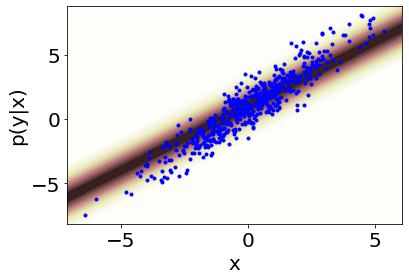

In [9]:
ep = 0.7
# make a grid that covers X
domX = torch.linspace(torch.min(X)-ep, torch.max(X)+ep, 100)
domY = torch.linspace(torch.min(Y).item()-ep, torch.max(Y).item()+ep, 200)

plot_2d_data_model(p, X, Y, domX, domY)

Note that our model is slightly wrong since it has a wrong slope.

### The Kernel Conditional Stein Discrepancy (KCSD) Test

In [10]:
# Our test requires two positive definite kernels: 
# one for x (denoted by k), the other one for y (denoted by l).
# Use Gaussian kernels for both X and Y.

# Let us use the median heuristic to pick the Gaussian bandwidths.
sigx = util.pt_meddistance(X, subsample=1000, seed=2)
sigy = util.pt_meddistance(Y, subsample=1000, seed=3)
        
# k = kernel on X. PTKGauss takes width **squared**.
k = ker.PTKGauss(sigma2=sigx**2)

# l = kernel on Y
l = ker.PTKGauss(sigma2=sigy**2)

In [11]:
# Construct a KCSD test object
# alpha = significant level for the test
# n_bootstrap = the number of times to run wild bootstrap to simulate 
# the null distribution. The larger, the better. 
# But reasonable to use a few hundreds at least.
# The model p is used here to construct the test along with kernels k, l.
kcsdtest = cgof.KCSDTest(p, k, l, alpha=0.05, n_bootstrap=500)

In [12]:
# perform the actual test on the data.
# The data (X,Y) are used here. Result is a dictionary.
result = kcsdtest.perform_test(X, Y)
result

{'alpha': 0.05,
 'pvalue': 0.0,
 'test_stat': 20.956090927124023,
 'h0_rejected': True,
 'n_simulate': 500,
 'time_secs': 0.41530394554138184}

It can be seen that the test rejects $H_0$ (i.e., `h0_rejected: True`) since the model is wrong. 


## Specifying the model $p(y|x)$ with $\nabla_y \log p(y|x)$

As mentioned, our tests rely on $\nabla_y \log p(y|x)$. If your model is such that it is easier to specify $\nabla_y \log p(y|x)$ directly (rather than $p(y|x)$) or you are sure that the automatic differentiable may not be efficient for your model, you can manually specify $\nabla_y \log p(y|x)$ as well.

Using the same as example from above, our model is 

$$p(y|x) = \mathcal{N}(y \mid slope \cdot x+c, variance).$$

So,


$$\nabla_y \log p(y|x) = - \frac{y - (slope\cdot x + c)}{variance}.$$


In [13]:
# Define a function that implements this score function 
# (the gradient of the log density above).
def simple_gaussian_model_score(X, Y):    
    slope = torch.tensor([1.0])
    c = 1.0
    variance = 1.0
    
    # Note that X (n x dx), Y (n x dy) are Torch tensors
    linear = torch.matmul(X, slope) + c
    
    # Return an n x dy Torch array.
    return -(Y-linear.view(-1, 1))/variance

To construct the model $p$, use

         kcgof.cdensity.from_grad_log(dx, dy, g)

In [14]:
# Model p(y|x)
p1 = cden.from_grad_log(dx, dy, simple_gaussian_model_score)

In [15]:
# Perform the test with p1
kcsdtest1 = cgof.KCSDTest(p1, k, l, alpha=0.05, n_bootstrap=500)
result1 = kcsdtest1.perform_test(X, Y)
result1

{'alpha': 0.05,
 'pvalue': 0.0,
 'test_stat': 20.956090927124023,
 'h0_rejected': True,
 'n_simulate': 500,
 'time_secs': 0.39121222496032715}

For the purpose of testing in our framework, `p` and `p1` are equivalent. In most cases, perhaps specifying the model with $\log p(y|x)$ is probably easier than $\nabla_y \log p(y|x)$.


### Exercise
Go back and change the slope of the model (of `p` or `p1`. Or try both) to match the data generating process. Now the model is correct. With probability roughly $1-\alpha$, the test will not reject. Try to change `c` and `variance` as well and see that the test will detect the discrepancy between the model and the data (as long as the discrepancy is large enough, and enough signal can be gathered from the data). Generally if the discrepancy is small, more data are needed to detect it.

This is the end of the tutorial for basic usage. Please feel free to open an issue on Github or contact us if you have questions or comments.

-----------------

The following code is doing a sanity check to make sure that $\nabla_y \log p(y|x)$ computed from both `p` and `p1` match.

In [16]:
X0 = X[:5, :]
Y0 = Y[:5, :]
p1.grad_log(X0, Y0)

tensor([[-2.2382],
        [-1.8113],
        [ 0.0059],
        [ 0.5779],
        [-1.6479]], grad_fn=<DivBackward0>)

In [17]:
p.grad_log(X0, Y0.detach())

tensor([[-2.2382],
        [-1.8113],
        [ 0.0059],
        [ 0.5779],
        [-1.6479]])